In [ ]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

import jax.numpy as jnp
import equinox as eqx

In this example, we solve a lineear elasticity problem of a circular inclusion in a square matrix. The inclusion is a material with a different elastic properties than the matrix. We use the Fourier-Galerkin method to solve the problem.

We import the necessary modules and set up the environment. The module `spectralsolvers` contains the operators and solvers for the Fourier-Galerkin method. We import the `fourier_galerkin` module to create the Fourier-Galerkin operator, `spatial` module to create the spatial operators, `tensor` module to create the tensor operators, and `fft` module to create the FFT and IFFT operators. We import the `conjugate_gradient_while` and `newton_krylov_solver` modules to create the solvers.


The module `plottwist` contains the plotting functions. The module `cmcrameri` contains the colormaps.

In [12]:
from spectralsolver.scheme import Fourier, SpectralSpace, RotatedDifference
from spectralsolver.projection_operator import GalerkinProjection
from spectralsolver import TensorOperator, make_field

from functools import partial

import matplotlib.pyplot as plt
from skimage.morphology import disk
import numpy as np
from jax import Array

In [4]:
from skimage.morphology import disk, rectangle, ellipse
from typing import Callable

import sys  
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt

To simplify the execution of the code, we define a `ElasticityOperator` class that contains the Fourier-Galerkin operator, the spatial operators, the tensor operators, and the FFT and IFFT operators. The `__init__` method initializes the operator and the `__call__` method computes the stresses in the real space given as 

$$
\mathcal{F}^{-1} \left( \mathbb{G}:\mathcal{F}(\sigma) \right)


$$

We define the grid size and the length of the RVE and construct the structure of the RVE.

In [5]:
from scipy.spatial.distance import cdist

def generate_multiphase_material_3d(size, num_phases=5, num_seeds=None, random_state=None):
    """
    Generate a 3D multiphase material using Voronoi tessellation.
    
    Parameters:
    -----------
    size : int or tuple of 3 ints
        Size of the 3D array. If int, creates a cubic array of size (size, size, size).
        If tuple, specifies (nx, ny, nz) dimensions.
    num_phases : int, default=5
        Number of different phases (materials) in the microstructure.
    num_seeds : int, optional
        Number of Voronoi seed points. If None, defaults to num_phases * 3.
    random_state : int, optional
        Random seed for reproducibility.
    
    Returns:
    --------
    material : numpy.ndarray
        3D array with values from 0 to 1, where each phase is represented by
        values in the range [i/num_phases, (i+1)/num_phases) for phase i.
    seed_points : numpy.ndarray
        Array of seed points used for Voronoi tessellation.
    """
    
    if random_state is not None:
        np.random.seed(random_state)
    
    # Handle size parameter
    if isinstance(size, int):
        nx, ny, nz = size, size, size
    else:
        nx, ny, nz = size
    
    # Default number of seeds
    if num_seeds is None:
        num_seeds = num_phases * 3
    
    # Generate random seed points in 3D space
    seed_points = np.random.rand(num_seeds, 3)
    seed_points[:, 0] *= nx
    seed_points[:, 1] *= ny
    seed_points[:, 2] *= nz
    
    # Assign each seed to a phase
    seed_phases = np.random.randint(0, num_phases, num_seeds)
    
    # Create coordinate grids
    x, y, z = np.meshgrid(np.arange(nx), np.arange(ny), np.arange(nz), indexing='ij')
    grid_points = np.column_stack([x.ravel(), y.ravel(), z.ravel()])
    
    # Calculate distances from each grid point to all seed points
    distances = cdist(grid_points, seed_points)
    
    # Find closest seed for each grid point
    closest_seeds = np.argmin(distances, axis=1)
    
    # Assign phases based on closest seed
    phase_array = seed_phases[closest_seeds].reshape(nx, ny, nz)
    
    # Convert to values between 0 and 1
    material = phase_array.astype(float) / num_phases + np.random.rand(nx, ny, nz) / (num_phases * 10)
    material = np.clip(material, 0, 1)
    
    return material, seed_points

In [25]:
N=31
length = 1.
ndim = 3


structure, seeds = generate_multiphase_material_3d(
        size=N, 
        num_phases=5, 
        num_seeds=15, 
        random_state=42
)

Next, we define the material parameters.

In [26]:
λ0 = structure.copy()
μ0 = structure.copy()

The linear elasticity strain energy is given as 
$$
W = \frac{1}{2} \int_{\Omega}  (\lambda \text{tr}(\epsilon)^2+ \mu \text{tr}(\epsilon : \epsilon ) ) d\Omega
$$

We define a python function to compute the strain energy and then use the `jax.jacrev` function to compute the stress tensor.

In [27]:
tensor = TensorOperator(dim=ndim)
space = SpectralSpace(size=N, dim=ndim, length=length)

In [28]:
galerkin_projection = GalerkinProjection(
    scheme=RotatedDifference(space=space), tensor_op=tensor
)
Ghat = galerkin_projection.compute_operator()

In [29]:
@jax.jit
def strain_energy(eps):
    eps_sym = 0.5 * (eps + tensor.trans(eps))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace(eps_sym) ** 2) + jnp.multiply(
        μ0, tensor.trace(tensor.dot(eps_sym, eps_sym))
    )
    return energy.sum()
# compute_stress = jax.jit(jax.jacrev(strain_energy))

I = make_field(dim=ndim, N=N, rank=2)
I[:, :, :, 0, 0] = 1
I[:, :, :, 1, 1] = 1
I[:, :, :, 2, 2] = 1

def compute_stress(eps):
    return jnp.einsum(
        "..., ...ij->...ij", λ0 * tensor.trace(eps), I
    ) + 2 * jnp.einsum("..., ...ij->...ij", μ0, eps)

In [30]:
eps = make_field(dim=ndim, N=N, rank=2)

In [31]:
class Residual(eqx.Module):
    """A callable module that computes the residual vector."""

    Ghat: Array
    space: SpectralSpace = eqx.field(static=True)
    tensor_op: TensorOperator = eqx.field(static=True)
    dofs_shape: tuple = eqx.field(static=True)

    # We can even pre-define the stress function if it's always the same
    # For this example, we'll keep your original `compute_stress` function
    # available in the global scope.

    @eqx.filter_jit
    def __call__(self, eps_flat: Array) -> Array:
        """
        This makes instances of this class behave like a function.
        It takes only the flattened vector of unknowns, as required by the solver.
        """
        eps = eps_flat.reshape(self.dofs_shape)
        sigma = compute_stress(eps)  # Assumes compute_stress is defined elsewhere
        residual_field = self.space.ifft(
            self.tensor_op.ddot(self.Ghat, self.space.fft(sigma))
        )
        return jnp.real(residual_field).reshape(-1)


class Jacobian(eqx.Module):
    """A callable module that represents the Jacobian operator (tangent)."""

    Ghat: Array
    space: SpectralSpace = eqx.field(static=True)
    tensor_op: TensorOperator = eqx.field(static=True)
    dofs_shape: tuple = eqx.field(static=True)

    @eqx.filter_jit
    def __call__(self, deps_flat: Array) -> Array:
        """
        The Jacobian is a linear operator, so its __call__ method
        represents the Jacobian-vector product.
        """
        deps = deps_flat.reshape(self.dofs_shape)
        # Assuming linear elasticity, the tangent is the same as the residual operator
        dsigma = compute_stress(deps)
        jvp_field = self.space.ifft(
            self.tensor_op.ddot(self.Ghat, self.space.fft(dsigma))
        )
        return jnp.real(jvp_field).reshape(-1)


In [32]:
residual_fn = Residual(Ghat=Ghat, space=space, tensor_op=tensor, dofs_shape=eps.shape)
jacobian_fn = Jacobian(Ghat=Ghat, space=space, tensor_op=tensor, dofs_shape=eps.shape)

In [33]:
from spectralsolver.solvers.nonlinear import (
    conjugate_gradient_while,
    newton_krylov_solver,
)

In [34]:
applied_strains = jnp.diff(jnp.linspace(0, 2e-1, num=5))

deps = make_field(dim=ndim, N=N, rank=2)

for inc, deps_avg in enumerate(applied_strains):
    # solving for elasticity
    deps[:, :, :, 0, 0] = deps_avg
    b = -residual_fn(deps)
    eps = eps + deps

    final_state = newton_krylov_solver(
        state=(deps, b, eps),
        gradient=residual_fn,
        jacobian=jacobian_fn,
        tol=1e-8,
        max_iter=20,
        krylov_solver=conjugate_gradient_while,
        krylov_tol=1e-8,
        krylov_max_iter=20,
    )
    eps = final_state[2]

Converged, Residual value : 9.940856065485507e-09
Converged, Residual value : 9.940884399753278e-09
Converged, Residual value : 9.940884658568433e-09
Converged, Residual value : 9.94088422188704e-09


In [35]:
stress00 = compute_stress(final_state[-1])[:, :, :, 1, 1]

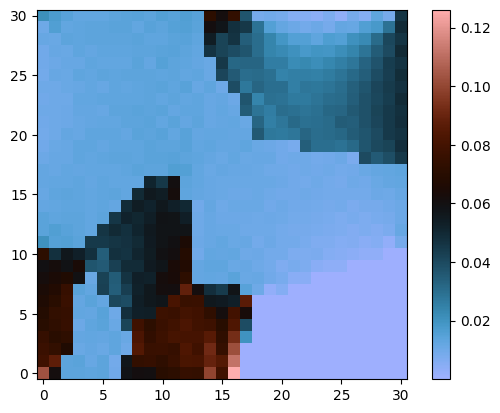

In [39]:
plt.figure()
plt.imshow(
    stress00.at[10, :, :].get() * (structure[10, :, :]),
    cmap=cmc.berlin, origin='lower'
)
plt.colorbar()
plt.show()

In [2]:
import pyvista

pyvista.set_jupyter_backend("client")
pyvista.start_xvfb()

In [18]:
# Create the spatial reference
grid = pyvista.ImageData(origin=(0, 0, 0))

# Set the grid dimensions: shape + 1 because we want to inject our values on
#   the CELL data
grid.dimensions = np.array(stress00.shape) + 1

# Add the data values to the cell data
grid.cell_data["stress"] = stress00.flatten(order="F")  # Flatten the array
grid.cell_data["structure"] = structure.flatten(order="F")  # Flatten the array

threshed = grid.threshold(value=(0.5), scalars='structure')


pl = pyvista.Plotter(shape=(1, 1))

_ = pl.add_volume(threshed, scalars="stress", cmap=cmc.roma)

camera = pyvista.Camera()
camera.position = (120.0,120.0, 120.0)
camera.focal_point = (5.0, -10.0, 5.0)
pl.camera = camera


pl.export_html(os.environ["PYVISTA_CACHE_DIR"] + "/pv.html")
#_ = pl.screenshot( os.environ["PYVISTA_CACHE_DIR"] + "/fft_pv.png")